In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

- **Продукт:** Shareware(PC) приложение (еженедельная/ежемесячная подписка), удаляющее мусор на физическом носителе
- **Тестируемое изменение:** отмена платежной системы для определенных пакетов. Теперь некоторые пакеты можно оплатить только определенной платежной системой, а не всеми. Хотим снизить расходы на комиссиях (поддерживать все платежки – дорого), благодаря изменению набора пакетов на платежку, которые можно приобрести (подверглись изменениям пакеты Yc и St). Будем сравнивать сумму списаний – не хочется терять деньги

In [49]:
df = pd.read_csv('hw4.csv', encoding='utf-8', delimiter=';', index_col=0)
df['orderRevenue'] = pd.to_numeric([i.replace(',','.') for i in df['orderRevenue'].values])
df.head()

,purchaseSystem,orderRevenue,experimentVariant
1,Pp,15.99,Treatment
2,Pp,17.99,Treatment
3,Pp,15.99,Treatment
4,Pp,15.99,Treatment
5,Pp,17.99,Treatment


In [5]:
df.shape

(1639, 3)

**Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста?**

In [7]:
df['experimentVariant'].value_counts()

Control      846
Treatment    793
Name: experimentVariant, dtype: int64

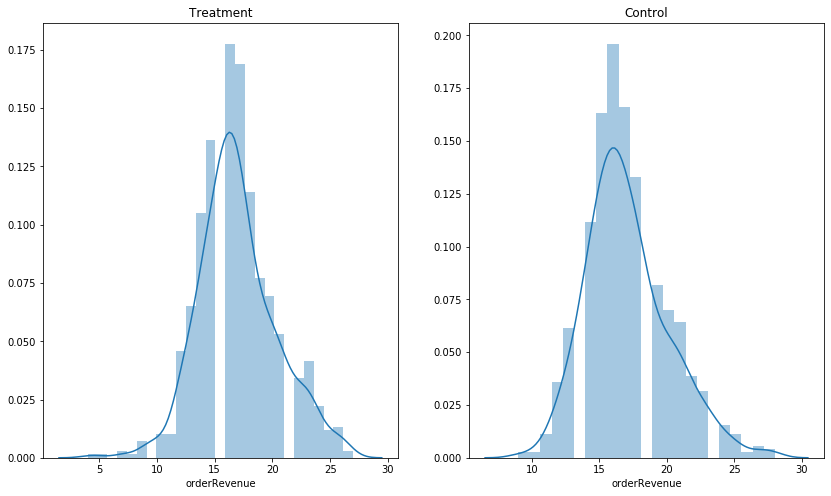

In [33]:
plt.figure(figsize=(14,8))

plt.subplot(121)
sns.distplot(df.loc[df['experimentVariant'] == 'Treatment', 'orderRevenue'])
plt.title('Treatment')

plt.subplot(122)
sns.distplot(df.loc[df['experimentVariant'] == 'Control', 'orderRevenue'])
plt.title('Control');

In [22]:
df.loc[df['experimentVariant'] == 'Treatment', 'orderRevenue'].describe()

count    793.000000
mean      16.972346
std        3.400415
min        3.990000
25%       14.990000
50%       16.990000
75%       18.990000
max       26.990000
Name: orderRevenue, dtype: float64

In [23]:
df.loc[df['experimentVariant'] == 'Control', 'orderRevenue'].describe()

count    846.000000
mean      17.059740
std        3.085159
min        8.990000
25%       14.990000
50%       16.990000
75%       18.990000
max       27.990000
Name: orderRevenue, dtype: float64

Проверим, является ли распределение нормальным

In [28]:
stat, p = kstest(df['orderRevenue'], 'norm')
p

0.0

Распределение является нормальным, дисперсии примерно равны. Можно применить двусторониий t-test.

In [36]:
stat, p = ttest_ind(df.loc[df['experimentVariant'] == 'Treatment', 'orderRevenue'],
                   df.loc[df['experimentVariant'] == 'Control', 'orderRevenue'])
p

0.5855070058877274

У нас нет оснований отвергнуть нулевую гипотезу о том, что среднее для Treatment больше или меньше, чем для Control. Изменения в сумме заказов между двумя статистически незначимо.

**Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста и платежной системы**

In [35]:
df['purchaseSystem'].value_counts()

Pp    1141
St     264
Yc     234
Name: purchaseSystem, dtype: int64

Можно применить множественную проверку гипотезы. Но можно сравнивать попарно. Применим коррекцию Бенджамини Хохберга
для уменьшения вероятности False Discovery Rate.

In [41]:
Pp = df.loc[df['purchaseSystem']=='Pp']
St = df.loc[df['purchaseSystem']=='St']
Yc = df.loc[df['purchaseSystem']=='Yc']

In [42]:
p_values = []

In [52]:
for value in list(df['purchaseSystem'].unique()):
    stat, p = kstest(df.loc[df['purchaseSystem']== value, 'orderRevenue'], 'norm')
    print(value, p)

Pp 0.0
St 0.0
Yc 0.0


In [43]:
stat, p = ttest_ind(Pp.loc[Pp['experimentVariant'] == 'Treatment', 'orderRevenue'],
                   Pp.loc[Pp['experimentVariant'] == 'Control', 'orderRevenue'])
p_values.append(p)

stat, p = ttest_ind(St.loc[St['experimentVariant'] == 'Treatment', 'orderRevenue'],
                   St.loc[St['experimentVariant'] == 'Control', 'orderRevenue'])
p_values.append(p)

stat, p = ttest_ind(Yc.loc[Yc['experimentVariant'] == 'Treatment', 'orderRevenue'],
                   Yc.loc[Yc['experimentVariant'] == 'Control', 'orderRevenue'])
p_values.append(p)

In [45]:
_, bh_p, _, _ = multipletests(p_values, method='fdr_bh')
bh_p

array([3.83641805e-01, 3.69480146e-03, 1.90683574e-09])

В этом случае есть основания отвергнуть нудевую гипотезу и говорить о том, что существуют различия в сумме заказов между Treatment
и Control в зависимости от платёжной системы. Лучше не отменять платёжные системы Yc и St.